In [1]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from PIL import Image
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torchvision.models import resnet18, efficientnet_b0, mobilenet_v2
from torchvision.models import ResNet18_Weights, EfficientNet_B0_Weights, MobileNet_V2_Weights
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, Subset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Check if it's using GPU
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


Using device: cpu
CUDA Available: False
GPU Name: No GPU found


In [17]:

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize((96, 96)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load STL-10 dataset
training_data = STL10(root="./data", split='train', download=True, transform=image_transform)
testing_data = STL10(root="./data", split='test', download=True, transform=image_transform)

# Create DataLoaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

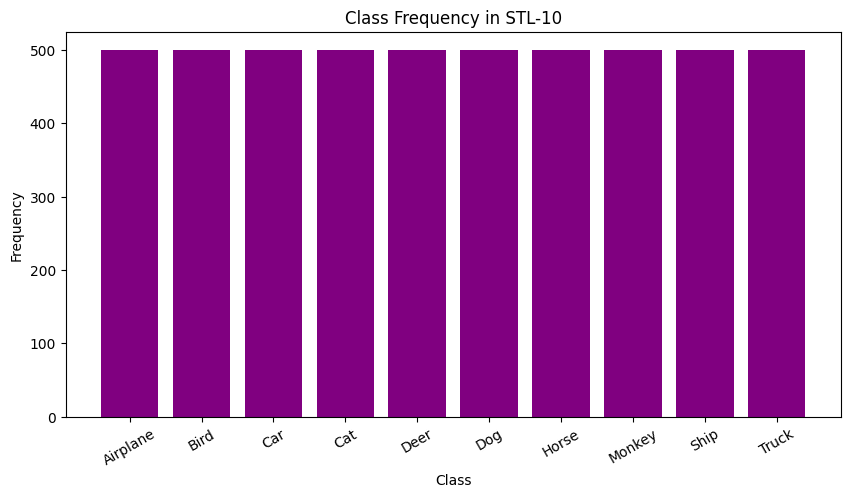

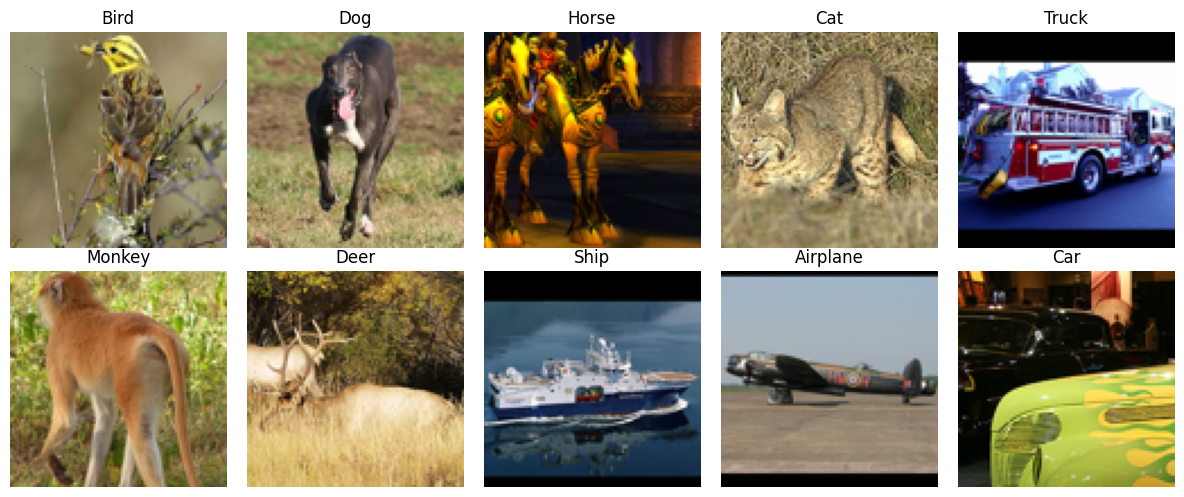

In [16]:
#EDA
class_names = {
    0: "Airplane",1: "Bird",2: "Car", 3: "Cat",4: "Deer",5: "Dog",6: "Horse",7: "Monkey",8: "Ship",9: "Truck"
}

training_data = STL10(root="./data", split="train", download=True, transform=ToTensor())


unique, counts = np.unique(training_data.labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values(), color="purple")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Frequency in STL-10")
plt.xticks(range(10), [class_names[i] for i in range(10)], rotation=30) 
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(12, 5)) 
axes = axes.flatten() 
selected_images = {}

for img, label in training_data:
    label = int(label)
    if label not in selected_images: 
        selected_images[label] = img
    if len(selected_images) == 10:
        break 


for i, (label, img) in enumerate(selected_images.items()):
    img = img.permute(1, 2, 0).numpy() 
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(class_names[label]) 

plt.tight_layout()
plt.show()


In [3]:

# Function to load models with modified final layers
def initialize_model(model_name):
    if model_name == "ResNet":
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        features = model.fc.in_features
        model.fc = nn.Linear(features, 10)  

    elif model_name == "EfficientNet":
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(features, 10)

    elif model_name == "MobileNet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(features, 10)

    return model.to(device)

# Initialize models
resnet_model = initialize_model("ResNet")
efficientnet_model = initialize_model("EfficientNet")
mobilenet_model = initialize_model("MobileNet")

# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()

resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-4)
mobilenet_optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001, weight_decay=1e-4)

# Function to train models and store losses
def train_model(model, optimizer, num_epochs=8):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training {model.__class__.__name__} - Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    
    return epoch_losses

# Train all models and store loss values
resnet_losses = train_model(resnet_model, resnet_optimizer)
efficientnet_losses = train_model(efficientnet_model, efficientnet_optimizer)
mobilenet_losses = train_model(mobilenet_model, mobilenet_optimizer)

# Function to evaluate accuracy
def compute_accuracy(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    
    return 100 * correct / total

# Compute accuracy for all models
resnet_accuracy = compute_accuracy(resnet_model)
efficientnet_accuracy = compute_accuracy(efficientnet_model)
mobilenet_accuracy = compute_accuracy(mobilenet_model)

print(f"ResNet Accuracy: {resnet_accuracy:.2f}%")
print(f"EfficientNet Accuracy: {efficientnet_accuracy:.2f}%")
print(f"MobileNet Accuracy: {mobilenet_accuracy:.2f}%")

 


Training ResNet - Epoch 1: 100%|█████████████████████████████████████████████████████| 157/157 [01:40<00:00,  1.56it/s]


Epoch 1, Loss: 1.0728


Training ResNet - Epoch 2: 100%|█████████████████████████████████████████████████████| 157/157 [01:40<00:00,  1.57it/s]


Epoch 2, Loss: 0.6704


Training ResNet - Epoch 3: 100%|█████████████████████████████████████████████████████| 157/157 [01:39<00:00,  1.58it/s]


Epoch 3, Loss: 0.4819


Training ResNet - Epoch 4: 100%|█████████████████████████████████████████████████████| 157/157 [01:43<00:00,  1.51it/s]


Epoch 4, Loss: 0.3770


Training ResNet - Epoch 5: 100%|█████████████████████████████████████████████████████| 157/157 [01:48<00:00,  1.44it/s]


Epoch 5, Loss: 0.3318


Training ResNet - Epoch 6: 100%|█████████████████████████████████████████████████████| 157/157 [01:46<00:00,  1.48it/s]


Epoch 6, Loss: 0.2150


Training ResNet - Epoch 7: 100%|█████████████████████████████████████████████████████| 157/157 [01:34<00:00,  1.66it/s]


Epoch 7, Loss: 0.2099


Training ResNet - Epoch 8: 100%|█████████████████████████████████████████████████████| 157/157 [01:40<00:00,  1.56it/s]


Epoch 8, Loss: 0.1806


Training EfficientNet - Epoch 1: 100%|███████████████████████████████████████████████| 157/157 [02:23<00:00,  1.09it/s]


Epoch 1, Loss: 0.8571


Training EfficientNet - Epoch 2: 100%|███████████████████████████████████████████████| 157/157 [02:25<00:00,  1.08it/s]


Epoch 2, Loss: 0.4530


Training EfficientNet - Epoch 3: 100%|███████████████████████████████████████████████| 157/157 [02:26<00:00,  1.07it/s]


Epoch 3, Loss: 0.3164


Training EfficientNet - Epoch 4: 100%|███████████████████████████████████████████████| 157/157 [02:15<00:00,  1.16it/s]


Epoch 4, Loss: 0.2389


Training EfficientNet - Epoch 5: 100%|███████████████████████████████████████████████| 157/157 [02:17<00:00,  1.14it/s]


Epoch 5, Loss: 0.1912


Training EfficientNet - Epoch 6: 100%|███████████████████████████████████████████████| 157/157 [02:17<00:00,  1.14it/s]


Epoch 6, Loss: 0.1792


Training EfficientNet - Epoch 7: 100%|███████████████████████████████████████████████| 157/157 [02:07<00:00,  1.23it/s]


Epoch 7, Loss: 0.1364


Training EfficientNet - Epoch 8: 100%|███████████████████████████████████████████████| 157/157 [01:59<00:00,  1.31it/s]


Epoch 8, Loss: 0.1232


Training MobileNetV2 - Epoch 1: 100%|████████████████████████████████████████████████| 157/157 [01:16<00:00,  2.05it/s]


Epoch 1, Loss: 0.9370


Training MobileNetV2 - Epoch 2: 100%|████████████████████████████████████████████████| 157/157 [01:16<00:00,  2.04it/s]


Epoch 2, Loss: 0.6060


Training MobileNetV2 - Epoch 3: 100%|████████████████████████████████████████████████| 157/157 [01:16<00:00,  2.05it/s]


Epoch 3, Loss: 0.4702


Training MobileNetV2 - Epoch 4: 100%|████████████████████████████████████████████████| 157/157 [01:18<00:00,  2.01it/s]


Epoch 4, Loss: 0.3760


Training MobileNetV2 - Epoch 5: 100%|████████████████████████████████████████████████| 157/157 [01:16<00:00,  2.05it/s]


Epoch 5, Loss: 0.3102


Training MobileNetV2 - Epoch 6: 100%|████████████████████████████████████████████████| 157/157 [01:16<00:00,  2.04it/s]


Epoch 6, Loss: 0.2755


Training MobileNetV2 - Epoch 7: 100%|████████████████████████████████████████████████| 157/157 [01:16<00:00,  2.05it/s]


Epoch 7, Loss: 0.2507


Training MobileNetV2 - Epoch 8: 100%|████████████████████████████████████████████████| 157/157 [01:17<00:00,  2.03it/s]


Epoch 8, Loss: 0.2235
ResNet Accuracy: 75.05%
EfficientNet Accuracy: 84.50%
MobileNet Accuracy: 81.16%


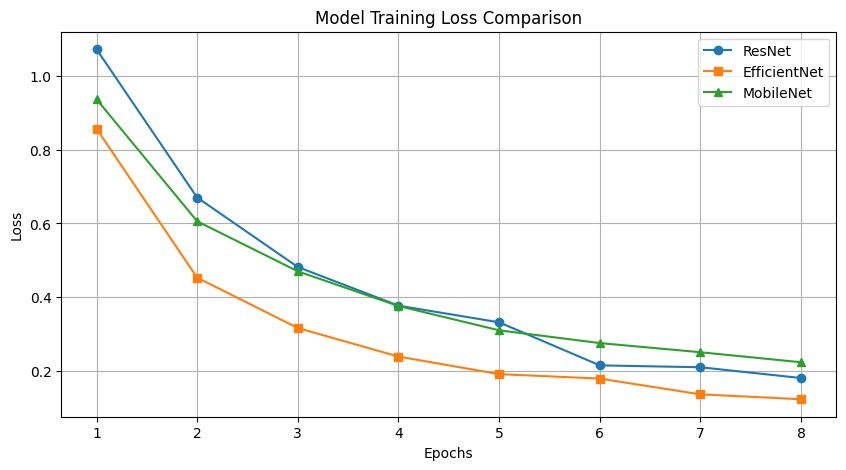

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), resnet_losses, label="ResNet", marker='o')
plt.plot(range(1, 9), efficientnet_losses, label="EfficientNet", marker='s')
plt.plot(range(1, 9), mobilenet_losses, label="MobileNet", marker='^')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training Loss Comparison")
plt.legend()
plt.grid()
plt.show()


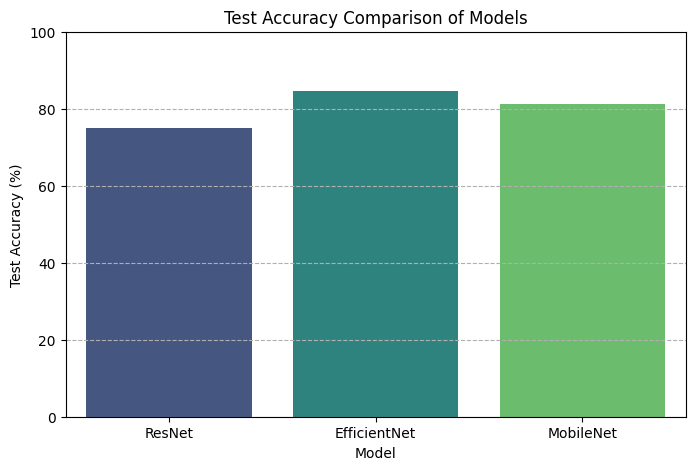

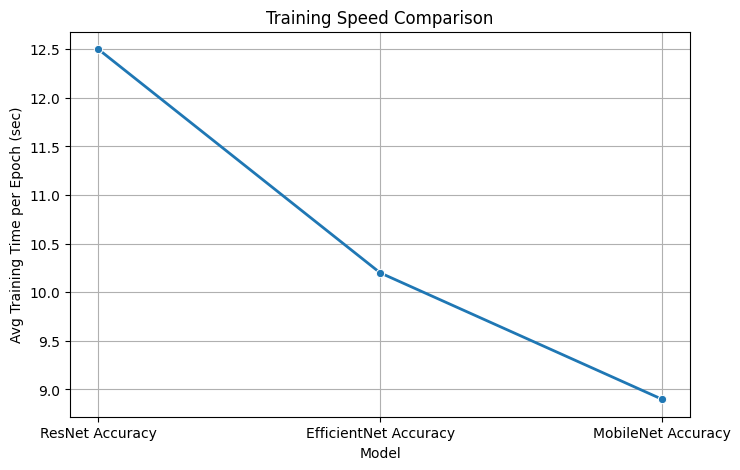

In [19]:
# Plot Accuracy Comparison (Bar Chart)
plt.figure(figsize=(8, 5))
sns.barplot(x=["ResNet", "EfficientNet", "MobileNet"], 
            y=[resnet_accuracy, efficientnet_accuracy, mobilenet_accuracy], 
            hue=["ResNet", "EfficientNet", "MobileNet"],  # Assign x variable to hue
            palette="viridis",
            legend=False)  # Disable legend

plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Comparison of Models")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle="--")
plt.show()
# Sample Training Time Data (replace with actual values)
resnet_time = 12.5  
efficientnet_time = 10.2
mobilenet_time = 8.9
# Plot Training Speed (Line Plot)
plt.figure(figsize=(8, 5))
sns.lineplot(x=["ResNet Accuracy", "EfficientNet Accuracy", "MobileNet Accuracy"], 
             y=[resnet_time, efficientnet_time, mobilenet_time], 
             marker="o", linestyle="-", linewidth=2)

plt.xlabel("Model")
plt.ylabel("Avg Training Time per Epoch (sec)")
plt.title("Training Speed Comparison")
plt.grid(True)
plt.show()




In [15]:

# Initialize EfficientNet
def initialize_efficientnet():
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1) 
    features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(features, 10)  #  10 classes
    return model.to(device)

# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
efficientnet_optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-4)

# Function to train EfficientNet
def train_model(model, optimizer, num_epochs=8):
    model.train()
    correct, total = 0, 0  

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training EfficientNet - Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # Compute train accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    return train_accuracy 


train_accuracy = train_model(efficientnet_model, efficientnet_optimizer)

# Function to compute test accuracy
def compute_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    
    return 100 * correct / total

# Compute test accuracy
test_accuracy = compute_accuracy(efficientnet_model, test_loader)

print(f"\nFinal Training Accuracy: {train_accuracy:.2f}%")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")






Training EfficientNet - Epoch 1: 100%|███████████████████████████████████████████████| 157/157 [02:01<00:00,  1.30it/s]


Epoch 1, Loss: 0.3514, Training Accuracy: 88.30%


Training EfficientNet - Epoch 2: 100%|███████████████████████████████████████████████| 157/157 [02:02<00:00,  1.28it/s]


Epoch 2, Loss: 0.2641, Training Accuracy: 89.67%


Training EfficientNet - Epoch 3: 100%|███████████████████████████████████████████████| 157/157 [02:03<00:00,  1.28it/s]


Epoch 3, Loss: 0.2120, Training Accuracy: 90.87%


Training EfficientNet - Epoch 4: 100%|███████████████████████████████████████████████| 157/157 [02:03<00:00,  1.27it/s]


Epoch 4, Loss: 0.1614, Training Accuracy: 91.82%


Training EfficientNet - Epoch 5: 100%|███████████████████████████████████████████████| 157/157 [02:05<00:00,  1.25it/s]


Epoch 5, Loss: 0.1518, Training Accuracy: 92.56%


Training EfficientNet - Epoch 6: 100%|███████████████████████████████████████████████| 157/157 [02:04<00:00,  1.26it/s]


Epoch 6, Loss: 0.1346, Training Accuracy: 93.02%


Training EfficientNet - Epoch 7: 100%|███████████████████████████████████████████████| 157/157 [02:03<00:00,  1.27it/s]


Epoch 7, Loss: 0.1192, Training Accuracy: 93.50%


Training EfficientNet - Epoch 8: 100%|███████████████████████████████████████████████| 157/157 [02:04<00:00,  1.26it/s]


Epoch 8, Loss: 0.1352, Training Accuracy: 93.80%

Final Training Accuracy: 93.80%
Final Test Accuracy: 86.25%


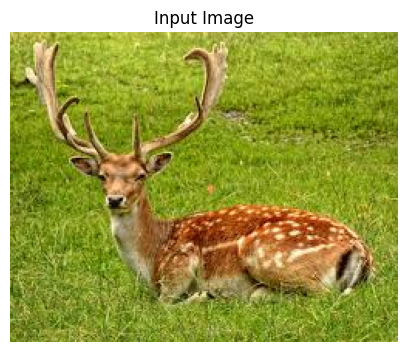

Predicted Class: deer


In [24]:


def predict_image_class(image_path_or_url, model):
    model.eval()

    if image_path_or_url.startswith("http"):
        response = requests.get(image_path_or_url)
        image = Image.open(response.raw).convert("RGB")
    else:
        image = Image.open(image_path_or_url).convert("RGB")


    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")  
    plt.title("Input Image")
    plt.show()

 
    image_tensor = image_transform(image).unsqueeze(0).to(device) 

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
    print(f"Predicted Class: {class_names[predicted.item()]}")
# Example Usage
image_path = r"E:\\Testing images\\3.jpg" 
predict_image_class(image_path, efficientnet_model)
